In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import cufflinks as cf
import plotly.plotly as py
warnings.filterwarnings('ignore')
import plotly
import os
os.path
from wordcloud.wordcloud import WordCloud
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

In [4]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})


# Ajustes en los archivos antes de procesar

In [5]:
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')

In [6]:
# Agrupo las áreas parecidas.
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [7]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [8]:
# Recorto la columna idpais ya que no es necesaria.
#avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [9]:
# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)


Timestamp('2018-04-15 17:32:24.959565')

In [10]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

# Merges necesarios 

In [11]:
usuarios_detalle = pd.merge(post_educacion, post_gen_edad, how='inner', left_on='idpostulante', right_on='idpostulante')
postulaciones_con_detalle_de_aviso = pd.merge(postulaciones, avisos_detalles, how='inner', left_on='idaviso', right_on='idaviso')
postulaciones_con_detalle_de_aviso_y_usuario = pd.merge(postulaciones_con_detalle_de_aviso, usuarios_detalle    , how='inner', left_on='idpostulante', right_on='idpostulante')
visitas_con_detalle_de_aviso = pd.merge(vistas, avisos_detalles     , how='inner', left_on='idAviso'     , right_on='idaviso')
visitas_con_detalle_de_aviso_y_usuario = pd.merge(visitas_con_detalle_de_aviso      , usuarios_detalle    , how='inner', left_on='idpostulante', right_on='idpostulante')

# Empieza el analisis

In [12]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [13]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [14]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [15]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [16]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [17]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,42.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


## Ver postulaciones de secundario en curso y vistas hechas al respecto (vistas, postulaciones, área de trabajo).


In [18]:
postulantes_sec = postulantes.loc[(postulantes['nombre'] == 'Secundario') & (postulantes['estado'] == 'En Curso')]
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0


In [19]:
#postulantes_1 = postulantes_sec[postulantes_sec.isna().any(axis=1)]
#null_columns=postulantes_sec.columns[postulantes_sec.isnull().any()]
#print(postulantes_sec[postulantes_sec.isnull().any(axis=1)][null_columns].head())
#aa = postulantes_sec.dropna(axis=0)

In [20]:
#pd.to_datetime(postulantes_sec['fechapostulacion'])
#postulantes_sec['edad'] = (now - pd.to_datetime(postulantes_sec['fechanacimiento'])).astype('<m8[Y]')
#dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_sec = postulantes_sec.loc[(postulantes_sec['edad'] >= 18) & (postulantes_sec['edad'] <= 65)]
#postulantes_sec.sort_values('age')
#veo el promedio de edad que utilizan la pagina y poseen secundario en curso
pd.to_numeric(postulantes_sec['edad'])

54977    41.0
54978    42.0
54979    32.0
54980    32.0
54981    34.0
54982    42.0
54983    35.0
54984    37.0
54985    36.0
54986    42.0
54987    33.0
54988    34.0
54989    42.0
54990    30.0
54991    40.0
54992    56.0
54993    31.0
54994    47.0
54995    31.0
54996    31.0
54997    33.0
54998    32.0
54999    30.0
55000    49.0
55001    37.0
55002    38.0
55003    28.0
55004    37.0
55005    33.0
55006    28.0
         ... 
58341    18.0
58342    30.0
58344    19.0
58345    18.0
58346    19.0
58347    21.0
58348    22.0
58349    36.0
58350    22.0
58351    37.0
58352    19.0
58353    19.0
58354    19.0
58355    19.0
58356    22.0
58357    18.0
58358    21.0
58360    21.0
58361    19.0
58362    18.0
58363    27.0
58364    18.0
58365    20.0
58366    19.0
58367    27.0
58368    18.0
58369    18.0
58370    22.0
58371    18.0
58372    19.0
Name: edad, Length: 3255, dtype: float64

In [21]:
#obtengo las decadas correspondientes para agrupar
postulantes_sec['decil'] = np.floor( postulantes_sec['edad'].apply(lambda x: x /10) )
postulantes_sec['decil'] = postulantes_sec['decil'].apply(lambda x: x*10)
postulantes_sec.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad,decil
54977,1qkm9z,Secundario,En Curso,5,1976-09-18,MASC,41.0,40.0
54978,YvjkMV,Secundario,En Curso,5,1975-06-18,FEM,42.0,40.0
54979,Y4oJ9w,Secundario,En Curso,5,1985-09-24,MASC,32.0,30.0
54980,5L5akv,Secundario,En Curso,5,1985-10-12,MASC,32.0,30.0
54981,6ZkmJR,Secundario,En Curso,5,1984-01-08,MASC,34.0,30.0


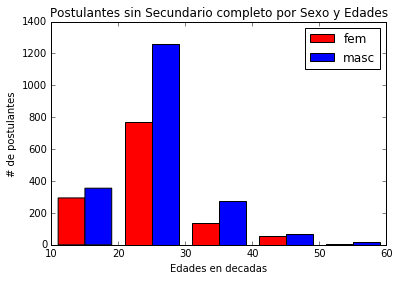

In [22]:
#diferencio entre mujeres y hombres
sec_fem = postulantes_sec.loc[postulantes_sec['sexo'] == 'FEM']
sec_masc = postulantes_sec.loc[postulantes_sec['sexo'] == 'MASC']
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes sin Secundario completo por Sexo y Edades')
plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['red', 'blue'], label=['fem','masc'])
plt.legend()

In [23]:
#veo las postulaciones que han hecho los que no poseen secundario completo
#ejemplo usado https://plot.ly/pandas/bubble-charts/
mergeo_sec = pd.merge(postulantes_sec, postulaciones)
agrup_sec = mergeo_sec.groupby(['idaviso']).size().to_frame(name='count').reset_index()
secs = pd.merge(avisos_detalles, agrup_sec, on='idaviso')
secs.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
#secs.sort_values(by='count',ascending=False)
secs_emp = secs[secs['count'] > 100]
secs_emp.sort_values(by='count',ascending=True)
secs_emp.iplot(kind='bubble', size='count', text='count', y='nombre_area', x='denominacion_empresa', mode='markers',
color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'], 
     opacity=[1, 0.8, 0.6, 0.4],filename='simple-bubble-chart',title='Postulaciones Secundario Incompleto')

### Por ello suponemos que una persona con secundario en curso se postula principalmente en mantenimiento y limpieza, ventas y en menor medida en produccion. 

# Ahora comparo con las vistas que hizo

In [24]:
sec_vistas = pd.merge(postulantes_sec, vistas)
sec_vistas = sec_vistas.rename(columns={"idAviso": "idaviso"})
secus_views = sec_vistas.groupby(['idaviso']).size().to_frame(name='count_vistas').reset_index()
secus_views_avisos = pd.merge(avisos_detalles, secus_views)
secus_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
sec_max = secus_views_avisos[secus_views_avisos['count_vistas'] > 40]
sec_max.sort_values(by='count_vistas', ascending=True, inplace=True)
sec_max.iplot(kind='bubble', size='count_vistas', text='count_vistas', y='nombre_area', x='denominacion_empresa', filename='simple-bubble-chart', title='Vistas postulantes Secundario Incompleto')

### En este ejemplo visualizamos que las vistas corresponden mayormente a Mantenimiento y Limpieza siguiendo muy de lejos el rubro ventas.

In [25]:
#Ahora veo como distinguir las vistas de las postulaciones
#df_secs = pd.DataFrame({'post':secs_emp, 'view': sec_max})
#secs_emp.head()
#merged = pd.merge(secs_emp, sec_max, on=['idaviso', 'idpais', 'tipo_de_trabajo', 'nivel_laboral', 'nombre_area', 'denominacion_empresa'], how='inner')
#merged.head()
#merged.iplot(kind='bubble', size='count_vistas', text='count_vistas', y='nombre_area', x='denominacion_empresa', filename='simple-bubble-chart', title='Vistas vs Postulaciones Secundario Incompleto', dimensions=)

# Voy a ver comparativamente con postulantes que poseen otros niveles de estudio.

In [26]:
#postulantes.head()
#postulaciones.head()
post_all = pd.merge(postulaciones, postulantes)
total_post = post_all.groupby(['idaviso']).size().to_frame(name='count_post').reset_index()
total_views_avisos = pd.merge(avisos_detalles, total_post)
total_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
total_views_avisos_min = total_views_avisos[total_views_avisos['count_post'] > 500]
total_views_avisos_min.iplot(kind='bubble', size='count_post', text='count_post', y='nivel_laboral', x='nombre_area', filename='simple-bubble-chart', title='Postulaciones totales por area y nivel laboral')

# Visualizo con graduados de posgrado

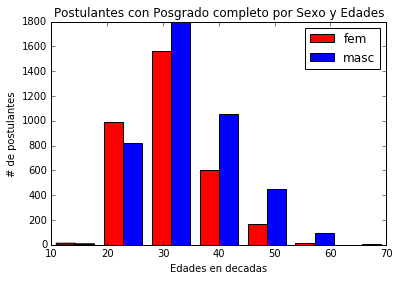

In [27]:
#post_all = pd.merge(postulaciones, postulantes)
#
postulantes_postgrado = postulantes[postulantes.valor_educacion > 15]
#obtengo las decadas correspondientes para agrupar
postulantes_postgrado['decil'] = np.floor( postulantes_postgrado['edad'].apply(lambda x: x /10) )
postulantes_postgrado['decil'] = postulantes_postgrado['decil'].apply(lambda x: x*10)
post_fem = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'FEM']
post_masc = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'MASC']
#post_fem = post_fem[post_fem['edad'] < 21]
#post_fem.head(50)
#post_fem[post_fem.edad < 24]
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes con Posgrado completo por Sexo y Edades')
plt.hist([post_fem['decil'].dropna(),post_masc['decil'].dropna()], bins=7, color=['red', 'blue'], label=['fem','masc'])
plt.legend()
plt.show()

### Me parece raro que menores de 20 años tengan posgrado en curso, o master, etc.

In [28]:
# Recorto la columna idpais ya que no es necesaria. --- ,import re flags = re.IGNORECASE
#avisos_detalles.drop(['mapacalle','ciudad','nombre_zona'], axis=1, inplace=True)
avisos_detalles['sexo'] = avisos_detalles.descripcion.str.lower().str.extract(r'(masculino|hombre|femenino|mujer)')
# avisos_detalles = avisos_detalles[avisos_detalles['nombre_area'] == 'Dirección y Liderazgo']
#pd.options.display.max_rows = None
df = pd.DataFrame(avisos_detalles.groupby(['nombre_area', 'sexo']).count())
df = df.dropna()
df.head()

idaviso  titulo  \
nombre_area                             sexo                         
Análisis Funcional                      mujer          1.0     1.0   
Arquitectura y Diseño                   femenino       2.0     2.0   
                                        hombre         2.0     2.0   
                                        masculino      4.0     4.0   
Asesoría Legal y Comercio Internacional femenino       1.0     1.0   

                                                   descripcion  nombre_zona  \
nombre_area                             sexo                                  
Análisis Funcional                      mujer              1.0          1.0   
Arquitectura y Diseño                   femenino           2.0          2.0   
                                        hombre             2.0          2.0   
                                        masculino          4.0          4.0   
Asesoría Legal y Comercio Internacional femenino           1.0          1.0   

                                                   ciudad  mapacalle  \
nombre_area                             sexo                           
Análisis Funcional                      mujer         0.0        0.0   
Arquitectura y Diseño                   femenino      0.0        1.0   
                                        hombre        0.0        0.0   
                                        masculino     0.0        0.0   
Asesoría Legal y Comercio Internacional femenino      0.0        0.0   

                                                   tipo_de_trabajo  \
nombre_area                             sexo                         
Análisis Funcional                      mujer                  1.0   
Arquitectura y Diseño                   femenino               2.0   
                                        hombre                 2.0   
                                        masculino              4.0   
Asesoría Legal y Comercio Internacional femenino               1.0   

                                                   nivel_laboral  \
nombre_area                             sexo                       
Análisis Funcional                      mujer                1.0   
Arquitectura y Diseño                   femenino             2.0   
                                        hombre               2.0   
                                        masculino            4.0   
Asesoría Legal y Comercio Internacional femenino             1.0   

                                                   denominacion_empresa  
nombre_area                             sexo                             
Análisis Funcional                      mujer                       1.0  
Arquitectura y Diseño                   femenino                    2.0  
                                        hombre                      2.0  
                                        masculino                   4.0  
Asesoría Legal y Comercio Internacional femenino                    1.0

### mujeres mas en consultorio pero piden mas hombres

In [29]:
avisos_detalles.describe()

,idaviso
count,1.288600e+04
mean,1.110856e+09
std,3.164357e+07
min,1.672250e+06
25%,1.112222e+09
50%,1.112278e+09
75%,1.112339e+09
max,1.112389e+09


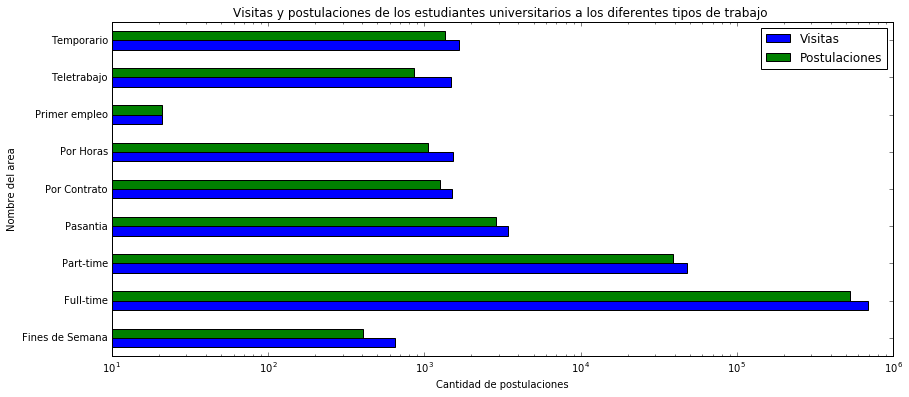

In [30]:
ax = plt.gca()

dataFrame = pd.DataFrame()

dataFrame['Visitas'] = (visitas_con_detalle_de_aviso_y_usuario[\
    (visitas_con_detalle_de_aviso_y_usuario.nombre == 'Universitario') &           
    (visitas_con_detalle_de_aviso_y_usuario.estado == 'Graduado')             
]).groupby(['tipo_de_trabajo'])['idaviso'].count()

dataFrame['Postulaciones'] = (postulaciones_con_detalle_de_aviso_y_usuario[\
    (postulaciones_con_detalle_de_aviso_y_usuario.nombre == 'Universitario') &                                                                   
    (postulaciones_con_detalle_de_aviso_y_usuario.estado == 'Graduado'     )                    
]).groupby(['tipo_de_trabajo'])['idaviso'].count() 

# Esta operacion es porque las visitas que provienen de CSV, solo cuentan las visitas que no terminaron en postulacion
dataFrame['Visitas'] = dataFrame['Visitas'] + dataFrame['Postulaciones']
                               
dataFrame.plot(kind='barh', figsize=(14,6), logx=True, ax=ax, title='Visitas y postulaciones de los estudiantes universitarios a los diferentes tipos de trabajo ');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

### En comparacion con los no graduados vemos una caida de los puestos laborales en forma de pasantia y vemos un aumento de los trabajos por contrato

### Vemos cosas interesantes en esta comparacion, primeramente que se intercambia el area de comercial y ventas con el area de contabilidad(podemos inferir que al recibirse pasan de ser vendedores a la contaduria o administrativos), ademas que el 3er puesto mas solicitado siendo universitario en curso es recepcionista/Secretaria siendo que no posee una carrera universitaria para ello, lo cual nos indica que se usa como medio para poder seguir estudiando.(esto se puede mejorar)

In [31]:
#avisos_detalles.head()
#postulaciones.head()
#post_max = pd.merge(postulaciones, postul, on='idaviso')
post_group =postulaciones.groupby('idaviso')['idpostulante'].count().reset_index()
post_group.rename(columns={'idpostulante':'cant_postulaciones'},inplace=True)
post_group.sort_values(by='cant_postulaciones',ascending=False,inplace=True)
post_group = pd.merge(post_group, avisos_detalles, on='idaviso')
post_group.head()

,idaviso,cant_postulaciones,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,sexo
0,1112033906,9932,Cajero/a-Repositor/a (Capital Federal),<p>Te estamos buscando para formar parte de nu...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Farmacity,NaN
1,1112334791,9787,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Farmacity,NaN
2,1112204682,9244,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Farmacity,NaN
3,1112094756,8763,Representante de Atencion al Cliente/ Banco,<p>Seleccionaremos para Importante Entidad Ban...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Comercial y Ventas,RANDSTAD,NaN
4,1112345900,8304,Asesores de Atención al Público - Part time,<p><em><strong>¡Sumate al equipo UP!</strong><...,Capital Federal,NaN,Palermo,Part-time,Junior,Consultoria,Universidad de Palermo,NaN


In [32]:
post_group.drop(['mapacalle','ciudad','nombre_zona','sexo','tipo_de_trabajo'],1,inplace=True)
post_max = post_group.head(20)
post_max

,idaviso,cant_postulaciones,titulo,descripcion,nivel_laboral,nombre_area,denominacion_empresa
0,1112033906,9932,Cajero/a-Repositor/a (Capital Federal),<p>Te estamos buscando para formar parte de nu...,Senior / Semi-Senior,Comercial y Ventas,Farmacity
1,1112334791,9787,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Senior / Semi-Senior,Comercial y Ventas,Farmacity
2,1112204682,9244,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Senior / Semi-Senior,Comercial y Ventas,Farmacity
3,1112094756,8763,Representante de Atencion al Cliente/ Banco,<p>Seleccionaremos para Importante Entidad Ban...,Senior / Semi-Senior,Comercial y Ventas,RANDSTAD
4,1112345900,8304,Asesores de Atención al Público - Part time,<p><em><strong>¡Sumate al equipo UP!</strong><...,Junior,Consultoria,Universidad de Palermo
5,1112319451,8025,Cajera/o (Capital Federal / Zona Norte),<p><strong>¡En FRÁVEGA tenemos nuevas OPORTUNI...,Senior / Semi-Senior,Contabilidad y Administración,Frávega
6,1112298966,7637,Representante de Atención al Cliente - Call C...,"<p><span lang=""ES"" style="""">Incorporaremos a n...",Junior,Comercial y Ventas,Fundación Favaloro
7,1112262494,7541,OPERADORES TELEFÓNICOS DE ATENCIÓN AL CLIENTE,"<p style="""">Buscamos Operadores Telefónicos pa...",Senior / Semi-Senior,Consultoria,BBVA Francés
8,1112305277,7153,CAJERO/A PART TIME - CABA,<p>Orientamos nuestra búsqueda a estudiantes ...,Junior,Contabilidad y Administración,BBVA Francés
9,1112296264,6968,Recepcionista Administrativa - Part Time,<p>Entre sus tareas mas importantes se encuent...,Junior,Recepcionista / Secretaria,Roilands Real Estate


In [33]:
post_max['descripcion'] = post_max['descripcion'].str.replace('<p>','')
post_max['descripcion'] = post_max['descripcion'].str.replace('<br />',' ')
post_max['descripcion'] = post_max['descripcion'].str.replace('</p>',' ')
post_max['descripcion'] = post_max['descripcion'].str.replace('<em>','')
post_max['descripcion'] = post_max['descripcion'].str.replace('</em>',' ')
post_max['descripcion'] = post_max['descripcion'].str.replace('<strong>','')
post_max['descripcion'] = post_max['descripcion'].str.replace('</strong>',' ')


In [34]:
pd.set_option('max_colwidth', 1500)
post_max.head()

,idaviso,cant_postulaciones,titulo,descripcion,nivel_laboral,nombre_area,denominacion_empresa
0,1112033906,9932,Cajero/a-Repositor/a (Capital Federal),"Te estamos buscando para formar parte de nuestro equipo de trabajo para nuestras sucursales de Farmacity. ¿Querés sumarte? Si tenes perfil comercial, terminaste tus estudios secundarios, te gusta trabajar y relacionarte con personas, este es tu lugar. ¿Qué buscamos? Personas con vocación de servicio para la atención de nuestros pacientes/clientes, dinámicas y proactivas, para las distintas sucursales de Capital federal, que posean disponibilidad para trabajar 6 días a la semana, 8hs por día (turno tarde-noche). ¿Qué ofrecemos? Excelentes condiciones laborales, posibilidades de desarrollo en un ambiente de trabajo que promueve la capacitación y un buen clima laboral. ¡Súmate a nuestro equipo! Para que podamos tener en cuenta tu CV, postulate haciendo clic en este link: https://career4.successfactors.com/sfcareer/jobreqcareer?jobId=4185&amp;company=farmacitysP&amp;username= Incentivamos a que se postulen perfiles de todas las edades",Senior / Semi-Senior,Comercial y Ventas,Farmacity
1,1112334791,9787,Cajero/a - Part Time,"Te estamos buscando para formar parte de un proyecto novedoso e innovador, para ocupar la posición de Cajero/a. Estaremos realizando la apertura de Simplicity, un nuevo formato de tiendas en la zona de Capital federal. ¿Queres formar parte de nuestro equipo? Si tenes perfil comercial, terminaste tus estudios secundarios, tenes ganas de enfrentar nuevos desafíos, te gusta trabajar en equipo y el relacionarte con personas, ¡súmate a nuestro equipo! ¿Que buscamos? Personas proactivas, con vocación de servicio y disponibilidad horaria para la atención de nuestros clientes. ¿Que ofrecemos? Excelentes condiciones laborales y posibilidades de desarrollo en un ambiente de trabajo que promueve la capacitación, un buen clima laboral y el trabajo en equipo. ¡Queremos que seas parte de este desafío! Para que podamos tener en cuenta tu CV, postulate haciendo clic en este link: https://career4.successfactors.com/sfcareer/jobreqcareer?jobId=4188&amp;company=farmacitysP&amp;username= Incentivamos a que se postulen perfiles de todas las edades",Senior / Semi-Senior,Comercial y Ventas,Farmacity
2,1112204682,9244,Cajero/a - Part Time,"Te estamos buscando para formar parte de un proyecto novedoso e innovador, para ocupar la posición de Cajero/a. Estaremos realizando la apertura de Simplicity, un nuevo formato de tiendas en la zona de Capital federal. ¿Queres formar parte de nuestro equipo? Si tenes perfil comercial, terminaste tus estudios secundarios, tenes ganas de enfrentar nuevos desafíos, te gusta trabajar en equipo y el relacionarte con personas, ¡súmate a nuestro equipo! ¿Que buscamos? Personas proactivas, con vocación de servicio y disponibilidad horaria para la atención de nuestros clientes. ¿Que ofrecemos? Excelentes condiciones laborales y posibilidades de desarrollo en un ambiente de trabajo que promueve la capacitación, un buen clima laboral y el trabajo en equipo. ¡Queremos que seas parte de este desafío! Para que podamos tener en cuenta tu CV, postulate haciendo clic en este link: https://career4.successfactors.com/sfcareer/jobreqcareer?jobId=4188&amp;company=farmacitysP&amp;username= Incentivamos a que se postulen perfiles de todas las edades",Senior / Semi-Senior,Comercial y Ventas,Farmacity
3,1112094756,8763,Representante de Atencion al Cliente/ Banco,"Seleccionaremos para Importante Entidad Bancaria, representantes de atencion al cliente para su centro de servicios en Capital Federal. Gestionaran consultas, reclamos y asesoraran a clientes y potenciales. Jornada laboral: 6 hs // 8 a 14 hs o de 14 a 20 hs Deberan contar con experiencia previa en posiciones afines. Estudios Universitarios en curso (excluyente). Sueldo de convenio Indicar pretensiones",Senior / Semi-Senior,Comercial y Ventas,RANDSTAD
4,1112345900,8304,Asesores de Atención al Público - Part time,"¡Su

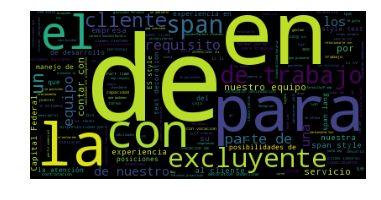

In [36]:
wordcloud2 = WordCloud().generate(' '.join(post_max['descripcion'])) #.generate(post_max['descripcion'])
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()